In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
def remove_rows_with_missing_ratings(df):
    df.dropna(subset=['Cleanliness_rating', 'Accuracy_rating', 'Communication_rating', 'Location_rating', 'Check-in_rating', 'Value_rating'], inplace=True)
    return df
  
def combine_description_strings(df):
    df.loc[:, 'Description'] = df['Description'].apply(lambda x: '' if pd.isna(x) else ' '.join([i for i in x if i != ""]).replace('About this space', '').strip())
    df = df.dropna(subset=['Description'])
    return df

def set_default_feature_values(df):
    df.loc[:, 'guests'] = df['guests'].apply(lambda x: 1 if pd.isna(x) else x)
    df.loc[:, 'beds'] = df['beds'].apply(lambda x: 1 if pd.isna(x) else x)
    df.loc[:, 'bathrooms'] = df['bathrooms'].apply(lambda x: 1 if pd.isna(x) else x)
    df.loc[:, 'bedrooms'] = df['bedrooms'].apply(lambda x: 1 if pd.isna(x) else x)
    return df

def clean_tabular_data(df):
    df = remove_rows_with_missing_ratings(df)
    df = combine_description_strings(df)
    df = set_default_feature_values(df)
    return df
    

In [3]:
def check_for_nan(df):
  return df.isnull().values.any()

In [4]:
def load_airbnb(label):
    # Load the cleaned tabular data
    df = pd.read_csv('C:/Users/dongc/Desktop/Code/python/AiCore/airbnb_model/tabular_data/tabular_data/clean_tabular_data_new.csv')
    
    # Select only the numerical columns as features
    features = df.select_dtypes(include=['float', 'int'])
    
    # Remove the label column from the features
    features = features.drop(columns=[label])
    features = features.drop(columns=['Unnamed: 19'])
    # Select the label column as the labels
    labels = df[label].dropna()
    
    return (features, labels)

In [5]:
class AirbnbNightlyPriceDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        # Convert the features and labels dataframes into torch tensors
        self.X = torch.tensor(features.values, dtype=torch.float32)
        self.y = torch.tensor(labels.values, dtype=torch.float32)

    def __getitem__(self, index):
        return (self.X[index], self.y[index].unsqueeze(dim=0))
    
    def __len__(self):
        return len(self.X)


In [6]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.af1 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.af1(x)
        x = self.fc3(x)
        return x

In [7]:
def train(model, dataloader, num_epochs, optimiser, criterion):
    optimiser = optimiser
    criterion = criterion
    for epoch in range(10):
        for i, (X, y) in enumerate(dataloader):
            # Forward pass
            try:
                output = model(X)
            except Exception as e:
                print(f"Error occurred on row {i}: {e}")
                continue
            
            loss = criterion(output, y)

            # Backward pass
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        # Break out of loop after first epoch
        break

Root Mean Squared Error: 104.19483438693705
R2 value: 0.34504199225193677


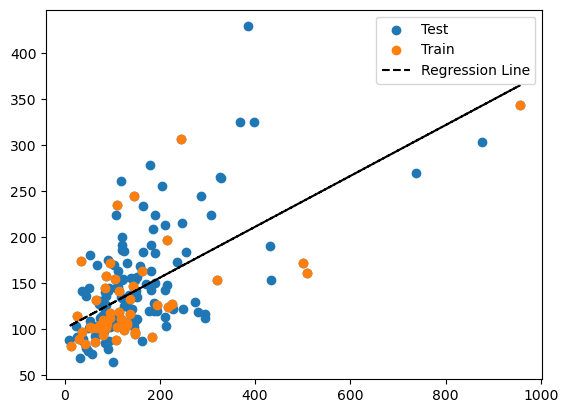

In [24]:
if __name__ == "__main__":
    # Load the tabular data
    df = pd.read_csv('C:/Users/dongc/Desktop/Code/python/AiCore/airbnb_model/tabular_data/tabular_data/listing.csv')

    # Clean the data
    df = clean_tabular_data(df)

    # Save the processed data
    df.to_csv('C:/Users/dongc/Desktop/Code/python/AiCore/airbnb_model/tabular_data/tabular_data/clean_tabular_data_new.csv', index=False)

    # Load the cleaned tabular data
    features, labels = load_airbnb(label='Price_Night')

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
    
    # Define the dataloaders
    batch_size = 128
    train_dataloader = DataLoader(AirbnbNightlyPriceDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(AirbnbNightlyPriceDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    # Define the model
    input_size = 9
    hidden_sizes = [5,3]
    output_size = 1
    model = FullyConnectedNet(input_size,hidden_sizes,output_size)

    # Define the optimizer and criterion
    optimiser = torch.optim.SGD(model.parameters(), lr=0.00002, momentum=0.7)
    criterion = torch.nn.MSELoss()

    # Train the model
    model.train()
    loss_accum=0
    
    for epoch in range(10000):
        
        for i, (X, y) in enumerate(train_dataloader):
            
            # Forward pass
            output = model(X)
            
            loss = criterion(output, y)
            loss_accum +=loss.item()
            
            # Backward pass
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

    # Test the model
    model.eval()
    with torch.no_grad():
        y_pred = []
        for X, y in test_dataloader:
            output = model(X)
            y_pred.append(output.numpy())
        y_pred = np.concatenate(y_pred)
 
    # Calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_val = r2_score(y_test, y_pred)
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R2 value: {r2_val}")

    # Log results into logs
    output_for_log = output.detach().numpy()
    y_for_log = y.detach().numpy()

    # Convert the lists of predicted and true labels to numpy arrays
    if isinstance(y_test,pd.Series):
        y_test = y_test.to_numpy().flatten()
    else:
        y_test = y_test.flatten()

    y_pred = y_pred.flatten()

    # Pull out the array within the list

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the real labels on the x-axis and the predictions on the y-axis
    ax.scatter(y_test, y_pred, label='Test')

    if len(y_for_log) == len(output_for_log):
        output_log = output_for_log
        ax.scatter(y_for_log, output_log, label = 'Train')

    # Fit a line to the data
    coefficients = np.polyfit(y_test, y_pred, 1)

    # Create a function object for the fitted line
    fit_fn = np.poly1d(coefficients)

    # Plot the fitted line
    ax.plot(y_test, fit_fn(y_test), '--k', label='Regression Line')

    # Add a legend and show the plot
    ax.legend()

    # Add a legend and show the plot
    ax.legend()
    plt.show()
